# Aligning signals from Music Lab mobile app trials

Experiment form of 16 trials of mixed stimuli and tasks (sitting in quiet, hearing music, talking, movement to music, select actions), on two participants and two phone positions each. 

Participant Movement recorded via three systems: 
1) Delsys motion capture system using ten markers
2) Sweetzpost respiration belt
3) Mobile phone accelerometer via MusicLab app

First task for assessing these signals is to align them to a common time frame. 

Details of trial recordings and file associations found at https://docs.google.com/spreadsheets/d/1lYFBzKTXrPHs2XA_qx7OVUX4a90C_PziQQ634WtA-7E/edit?usp=sharing

In [2]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## reinterpolate and filter signals for alignment

First load related files of a single trial

KB_T4	T6.mp3	KB_Trial_04Redo.tsv	1615899714492	data_part2_trial_4_Stim_T6.csv	
Resp start	Mobile start	Stim
6	8	13

In [186]:
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/')
trail_wise = pd.read_csv('trial_wise.csv')
trail_seq = pd.read_csv('Trial_Stim.csv')
trial_times=trail_seq.iloc[:,:2].copy()
trial_times['Time (ms)'] = units*trial_times['Time (s)']
trial_times=trial_times.set_index("Time (ms)", drop=True)

In [189]:
# trial timing information
trial_n =5

# Trial to test
trial_name = trail_wise.loc[trial_n,'Participant'] + '_' + trail_wise.loc[trial_n,'Trial stim']

# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
mob = pd.read_csv(trail_wise.loc[trial_n,'Mobile_file'])

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/' + str(trail_wise.loc[trial_n,'Resp_file']) + '/')
filename = 'Breathing2.csv'
g = pd.read_csv(filename,',',header=None,names=['0','1','2','3','4','5'])
resp_init = g.loc[g['1']=='force']
respdelay = resp_init.iloc[0,0] - g.iloc[0,0]
print('resp belt sensor connection delay ' + str(respdelay/1000) + 's' )

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
m = pd.read_csv(trail_wise.loc[trial_n,'mocap_file'], sep='\t',header=None,names=['HEADT X', 'HEADT Y', 'HEADT Z', 'SHL X', 'SHL Y','SHL Z','SHR X', 'SHR Y', 'SHR Z','CH X', 'CH Y', 'CH Z'])
mocap = m.loc[~m['CH Z'].isna(),:]
mocap.loc[:,'Time (ms)'] = (np.arange(0,len(mocap),)*units/120) - trail_wise.loc[trial_n,'Stim']*units
trail_wise.loc[trial_n,:]

resp belt sensor connection delay 14.917s


filename                             DS_T4.qtm
Data type                               Mocap 
Resp start                                 4.0
Mobile start                               7.0
Stim                                        12
Trial stim                                  T4
Participant                                 DS
Trial order                                  6
Mobile loc                                  12
Music Move                            Standing
Move Act                          Remove phone
Resp_file                        1615822538057
Mobile_file     data_part1_trial_6_Stim_T4.csv
mocap_file                           DS_T4.tsv
Name: 5, dtype: object

In [147]:
# conditions for comparison 246900 289766
units = 1000 # ms
fs = 10/units # 10 Hz

cutoff = np.array([2])/units # filtering to between 1 and 0.05 hz
nyq = 0.5 * fs 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

In [190]:
# set time to stim zero (approx)
mob['Time (ms)'] = (mob['time']-mob['time'].loc[0])-(trail_wise.loc[trial_n,'Stim']-trail_wise.loc[trial_n,'Mobile start'])*units # Time is time zero

df = mob
#cols = list(mob.columns)
cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']

time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)-np.median(f(time_new))
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mob_rs = df_rs.copy()

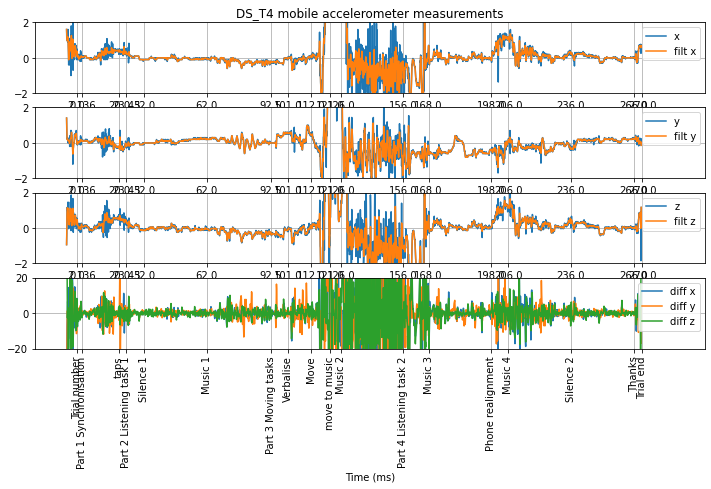

In [191]:
t_range = np.array([-20,300])*units
fig = plt.figure(figsize=(12,6))
dims = ['x', 'y', 'z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-2,2)
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    if i == 0: plt.title(trial_name + ' mobile accelerometer measurements')

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-20,20)
    plt.xlim(t_range)
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()

plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])

plt.savefig('filtered_Mobile.png',dpi = 200)
plt.show()


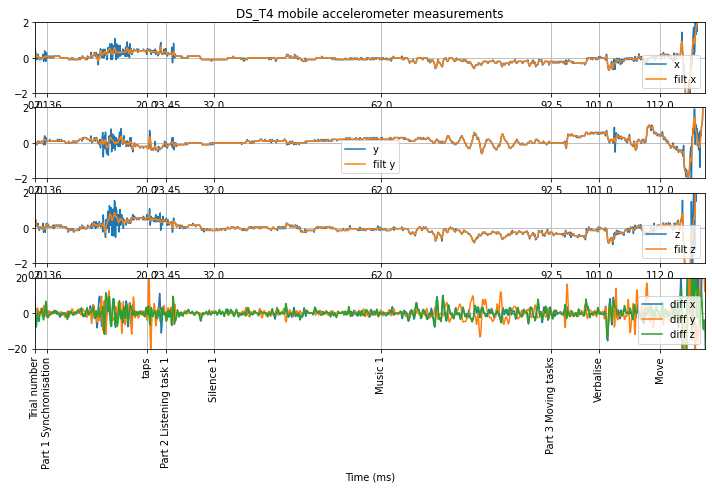

In [192]:
t_range = np.array([0,120])*units
fig = plt.figure(figsize=(12,6))
dims = ['x', 'y', 'z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-2,2)
    if i == 0: plt.title(trial_name + ' mobile accelerometer measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-20,20)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)

plt.savefig('filtered_Mobile_ex_' + trial_name + '.png',dpi = 200)
plt.show()


In [193]:
resp = pd.DataFrame()
resp['belt'] = resp_init['3']
resp['Time (ms)'] = respdelay+(resp_init['5']-resp_init.iloc[0,5]) -(trail_wise.loc[trial_n,'Stim']-trail_wise.loc[trial_n,'Resp start'])*units
df = resp.copy()
#cols = list(mob.columns)
cols = ['belt']
print(cols)

time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c]) - np.median(filtfilt(b, a, df_rs[c]))
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

resp_rs = df_rs.copy()
resp_rs

['belt']


,Time (s),belt,filt belt,diff belt
Time (ms),,,,
6917.0,6.917,1720.0,-6.135095,-7.274359
7017.0,7.017,1710.0,-13.473458,-5.249856
7117.0,7.117,1709.0,-18.439371,-3.100661
7217.0,7.217,1706.0,-20.740587,-1.021154
7317.0,7.317,1703.0,-20.832686,0.393665
...,...,...,...,...
273717.0,273.717,1809.0,83.630460,-3.215327
273817.0,273.817,1808.0,81.340133,-1.335553
273917.0,273.917,1806.0,80.500276,-1.036438


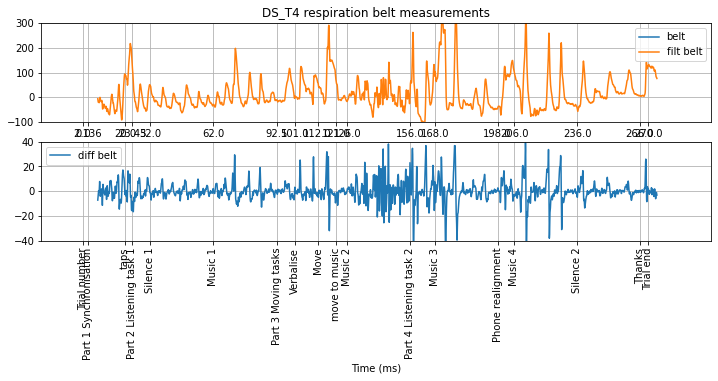

In [194]:
t_range = np.array([-20,300])*units
fig = plt.figure(figsize=(12,4))
dims = ['belt']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(211 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-100,300)
    if i == 0: plt.title(trial_name + ' respiration belt measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
    
ax = plt.subplot(212)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-40,40)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
    
plt.savefig('filtered_Resp.png',dpi = 200)
plt.show()


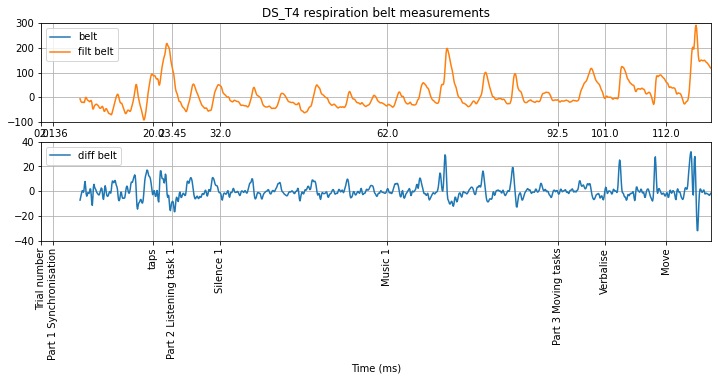

In [195]:
t_range = np.array([0,120])*units
fig = plt.figure(figsize=(12,4))
dims = ['belt']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(211 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-100,300)
    if i == 0: plt.title(trial_name + ' respiration belt measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
    
ax = plt.subplot(212)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-40,40)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
plt.savefig('filtered_Resp_ex_' + trial_name + '.png',dpi = 200)
plt.show()


In [124]:
# TODO rotate CH ZY to be closer to the mobile XY according to the recorded angles of the phone. 

In [196]:
df = mocap.copy()
cols = df.columns
time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols[:-1]:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])-np.median(filtfilt(b, a, df_rs[c]))
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mocap_rs = df_rs.copy()
mocap_rs

,Time (s),HEADT X,filt HEADT X,diff HEADT X,HEADT Y,filt HEADT Y,diff HEADT Y,HEADT Z,filt HEADT Z,diff HEADT Z,...,diff SHR Z,CH X,filt CH X,diff CH X,CH Y,filt CH Y,diff CH Y,CH Z,filt CH Z,diff CH Z
Time (ms),,,,,,,,,,,,,,,,,,,,,
-12000.0,-12.0,-280.011,-38.637023,-0.833181,-29.617,-8.991375,-2.463749,1297.808,-1.091013,0.583453,...,-9.857933,-280.273,6.860681,3.555133,-158.237,-5.310978,-11.098874,1012.634,7.153226,3.542044
-11900.0,-11.9,-280.552,-38.960219,-0.240731,-30.338,-9.667843,-1.122311,1297.990,-1.044318,0.103784,...,-6.432199,-278.688,7.401215,1.002512,-160.571,-6.224703,-3.690193,1013.847,7.298807,-0.942306
-11800.0,-11.8,-280.525,-38.926817,0.255238,-30.826,-9.838218,0.267285,1297.737,-1.062807,-0.259555,...,-1.717980,-280.180,7.336270,-0.780414,-158.554,-6.222955,2.323087,1011.893,6.942156,-3.772492
-11700.0,-11.7,-279.739,-38.652961,0.349098,-30.109,-9.466163,0.991661,1297.847,-1.114861,-0.093675,...,3.409905,-280.317,7.030989,-0.651036,-158.374,-5.650586,3.951938,1011.850,6.453795,-2.387690
-11600.0,-11.6,-279.692,-38.506569,0.112707,-29.362,-9.089957,0.364813,1297.897,-1.088266,1.258797,...,5.847257,-280.505,7.027421,-0.295336,-158.286,-5.246291,1.394846,1011.865,6.407330,1.614408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276700.0,276.7,700.085,943.042241,72.112183,376.803,398.111946,108.351083,1723.451,427.787360,152.753529,...,0.020938,689.988,977.983555,288.803569,206.529,361.390496,395.358556,1444.915,444.144605,103.401223
276800.0,276.8,747.982,989.585351,77.300920,423.775,446.358057,150.738221,1747.092,448.199645,123.327028,...,-0.000298,761.586,1048.056793,289.071047,263.888,416.591152,510.245937,1462.157,457.341714,103.401687
276900.0,276.9,797.088,1036.097804,72.758285,491.458,511.851888,194.301043,1763.527,461.305720,46.687969,...,-0.004210,829.094,1115.118147,268.308495,333.608,487.490294,636.767652,1476.897,467.305860,39.643849


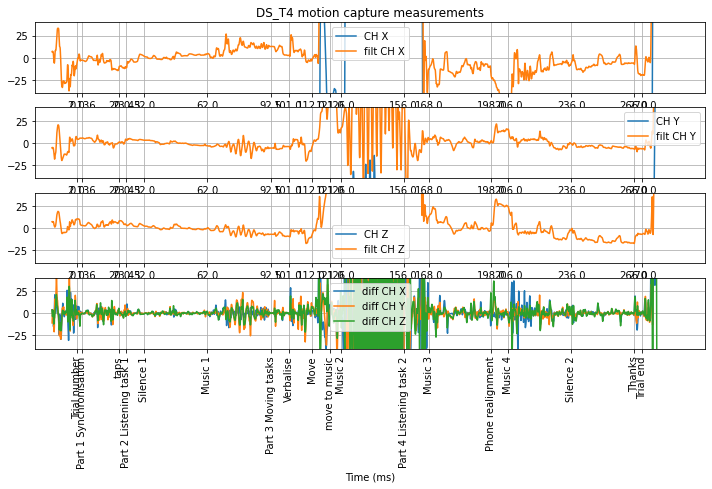

In [198]:
#t_range = np.array([0,120])*units
t_range = np.array([-20,300])*units

markers = ['CH']
dims = ['X','Y','Z']
for m in markers:
    fig = plt.figure(figsize=(12,6))
    for i in range(len(dims)):
        d = dims[i]
        ax = plt.subplot(411 + i)
        df_rs.plot.line(y= m + ' ' + d,ax=ax)
        df_rs.plot.line(y='filt ' + m + ' ' + d,ax=ax)
        plt.xlim(t_range)
        plt.ylim(-40,40)
        if i == 0: plt.title(trial_name + ' motion capture measurements')
        plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
        plt.grid()
        plt.xlim(t_range)

    ax = plt.subplot(414)
    for d in dims:
        df_rs.plot.line(y='diff ' + m + ' ' + d,ax=ax)
        plt.ylim(-40,40)
        plt.xticks(trial_times.index,trial_times["Element"],rotation='vertical')#, concert_times['event'])
        plt.grid()
        plt.xlim(t_range)

#plt.savefig('filtered_mocap_CH_ex_' + trial_name + '.png',dpi = 200)
plt.savefig('filtered_CH.png',dpi = 200)
plt.show()


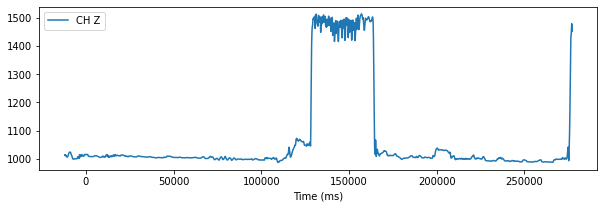

,HEADT X,HEADT Y,HEADT Z,SHL X,SHL Y,SHL Z,SHR X,SHR Y,SHR Z,CH X,CH Y,CH Z,Time (ms)
11,-280.011,-29.617,1297.808,-289.851,184.250,1009.990,-183.877,69.057,947.898,-280.273,-158.237,1012.634,-12000.000000
12,-279.980,-29.599,1297.840,-289.867,184.197,1009.993,-183.831,68.931,948.148,-280.402,-158.297,1012.609,-11991.666667
13,-279.945,-29.604,1297.849,-289.878,184.160,1009.997,-183.832,68.861,948.054,-280.368,-158.290,1012.732,-11983.333333
14,-279.940,-29.649,1297.851,-289.572,184.257,1009.952,-183.830,68.342,947.380,-280.551,-158.411,1012.470,-11975.000000
15,-279.943,-29.681,1297.855,-289.578,184.217,1009.945,-183.774,68.256,947.191,-280.583,-158.468,1012.445,-11966.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-313.480,-37.315,1304.999,-324.305,179.301,1007.706,-215.074,62.323,955.920,-323.789,-161.038,1005.391,-3791.666667
997,-313.019,-37.566,1305.291,-323.658,179.022,1008.157,0.000,0.000,0.000,-323.085,-160.595,1005.997,-3783.333333
998,-312.569,-37.824,1305.530,-322.966,178.774,1008.699,-215.300,61.994,956.065,-322.189,-160.008,1006.663,-3775.000000
999,-312.140,-38.099,1305.820,-322.368,178.402,1009.353,-214.887,61.871,956.354,-321.406,-159.257,1007.603,-3766.666667


In [201]:
mocap.plot.line(x = 'Time (ms)',y='CH Z',figsize=(10,3))
# plt.xlim(0,60000)
# plt.ylim(950,1000)
plt.show()
mocap.loc[:1000]

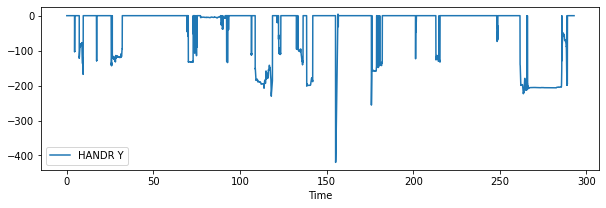

,Frame,Time,HEADT X,HEADT Y,HEADT Z,SHL X,SHL Y,SHL Z,SHR X,SHR Y,...,MOBTR X,MOBTR Y,MOBTR Z,HANDR X,HANDR Y,HANDR Z,HANDL X,HANDL Y,HANDL Z,Unnamed: 32
0,1,0.00000,-168.037,-108.186,1297.724,-127.877,108.314,1007.817,-157.337,-256.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2,0.00833,-167.954,-107.989,1297.663,-127.798,108.400,1007.907,-156.906,-256.265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,3,0.01667,-167.864,-107.780,1297.636,-127.740,108.504,1008.046,-156.445,-256.223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,4,0.02500,-167.751,-107.582,1297.574,-127.637,108.604,1008.192,-156.128,-256.243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,5,0.03333,-167.648,-107.370,1297.529,-127.569,108.675,1008.291,-155.806,-256.307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,6,0.04167,-167.549,-107.176,1297.482,-127.473,108.748,1008.364,-155.548,-256.350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,7,0.05000,-167.416,-106.948,1297.435,-127.364,108.811,1008.409,-155.342,-256.367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,8,0.05833,-167.278,-106.733,1297.384,-127.267,108.861,1008.429,-155.028,-256.328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8,9,0.06667,-167.087,-106.509,1297.294,-127.132,108.926,1008.379,-154.748,-256.290,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9,10,0.07500,-166.971,-106.270,1297.280,-127.061,108.998,1008.386,-154.475,-256.373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [26]:
mocap.plot.line(x = 'Time',y='HANDR Y',figsize=(10,3))
#plt.xlim(28000,35000)
#plt.ylim(950,1000)
plt.savefig('hand.png',dpi = 200)

plt.show()
mocap.loc[:10]

In [27]:
# 2892 2748
len(mob_rs)

2779

# align mocap and mobile
compare chest location data with mobile movement to see if we can align them reliably 

In [ ]:
#these alignments can then be refined
M1_rs = mocap_rs.iloc[:,-9:]
M1_rs['Time (s)'] = mocap['Time']/1000
M2_rs = mob_rs
#mob_rs['sTime0'] = mob_rs.index - 3*units

In [ ]:
# for all combinations of dimensions and features, determine best cross correlation offset
cols1 = M1_rs.columns
print(cols1)
cols2 = M2_rs.columns
print(cols2)
C1 = cols1[1]
C2 = cols2[2]
length = np.min([len(M1_rs),len(M2_rs)])
# print( C1 + ' ' + C2 + ' corr r=' + str(max_r) + ' offset = ' + )
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(211)
ax1.xcorr(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], usevlines=True, maxlags=600, normed=True, lw=3)
ax1.grid(True)
xc = np.correlate(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], "full")
print([C1, C2, np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid


In [ ]:
xc

In [ ]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
xcov_monthly = [crosscorr(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], lag=i) for i in range(12)]

In [ ]:
xcov_monthly

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


In [ ]:
cols1 = M1_rs.columns
print(cols1)
cols2 = M2_rs.columns

C2 = cols2[5]
print(C2)
for C1 in cols1:
    d1 = M1_rs[C1].iloc[:length]
    d2 = M2_rs[C2].iloc[:length]
    seconds = 50
    fps = 10
    #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rs = [d1.corr(d2.shift(lag)) for lag in range(-int(seconds*fps),int(seconds*fps+1))]

    offset = np.floor(len(rs)/2)-np.argmax(rs)
    r = np.max(rs)

    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'{C1} {C2} Offset = {offset} frames with r = {r} \nS1 leads <> S2 leads',ylim=[-.5,.5], xlabel='Offset',ylabel='Pearson r')
    #ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
    #ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt.legend()
    plt.show()

In [ ]:
cols1 = M1_rs.columns
cols2 = M2_rs.columns
alignments = pd.DataFrame()

for C2 in cols2[1:10]:
    for C1 in cols1[:-1]:
        d1 = M1_rs[C1].iloc[:length]
        d2 = M2_rs[C2].iloc[:length]
        seconds = 50
        fps = 10
        #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rs = [d1.corr(d2.shift(lag)) for lag in range(-int(seconds*fps),int(seconds*fps+1))]

        offset = np.floor(len(rs)/2)-np.argmax(rs)
        r = np.max(rs)
        alignments= alignments.append({'S1':C1,'S2':C2,'offset (s)':offset/fps,'r': r},ignore_index=True)
alignments

In [ ]:
alignments.max()
np.argmax(alignments['r'])

In [ ]:
alignments.loc[40]

# Alignment testing 
Compare the signals take from the respiration belt and the mobile device and the motion capture measurements (CH and HEADT).


first to align,
Then to evaluate share in formation. 

In [ ]:
#these alignments can then be refined
mocap_rs['sTime0'] = mocap_rs.index - 9*units
resp_rs['sTime0'] = resp_rs.index - 5*units
mob_rs['sTime0'] = mob_rs.index - 3*units


In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

ax = plt.subplot(212)
tag =  'diff CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)
plt.savefig('Cross_sensor.png',dpi = 200)

plt.show()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

In [ ]:
compSig = pd.DataFrame(index = mocap_rs['sTime0'])
compSig["MC"] = mocap_rs['diff CH Z']/np.median(np.abs(mocap_rs['diff CH Z']))
compSig["Belt"] = resp_rs['diff belt']/np.median(np.abs(resp_rs['diff belt']))
compSig["MB"] = mob_rs['diff x']/np.median(np.abs(mob_rs['diff x'])) # arbitrary scaling factor
st = resp_rs['sTime0'].iloc[5]
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.plot()

d_Range.corr()
#sp.stats.pearsonr(DRB['Raw'],DRB['CH Z'])[0]
# sp.stats.pearsonr(d_Range['diff belt'],d_Range['diff CH Z'])[0]


In [ ]:
st = 0
et = st + 120000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
d_Range.corr()

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(d_Range['Belt'],d_Range['MC'], usevlines=True, maxlags=600, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MC'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500.0
st = et - 120000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['Belt'],d_Range['MC'], usevlines=True, maxlags=600, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MC'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:
#these alignments can then be refined
mocap_rs['sTime0'] = mocap_rs.index - 0*units
resp_rs['sTime0'] = resp_rs.index + 113100 #0*units
#mob_rs['sTime0'] = mob_rs.index - 0*units

compSig = pd.DataFrame(index = mocap_rs['sTime0'])
compSig["MC"] = mocap_rs['diff CH Z']/np.median(np.abs(mocap_rs['diff CH Z']))
compSig["Belt"] = resp_rs['diff belt']/np.median(np.abs(resp_rs['diff belt']))
#compSig["MB"] = mob_rs['diff x']/np.median(np.abs(mob_rs['diff x'])) # arbitrary scaling factor

st = resp_rs['sTime0'].iloc[5]
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.plot()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
# tag =  'filt x'
# mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

ax = plt.subplot(212)
tag =  'diff CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
# tag =  'diff x'
# mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)
# plt.savefig('Cross_sensor.png',dpi = 200)

plt.show()

In [ ]:
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()

# MC	Belt	MB
# sTime0			

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
st = 20000
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()
ax1.xcorr(d_Range['Belt'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500
st = et - 60000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['Belt'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()

# MC	Belt	MB
# sTime0			

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()
ax1.xcorr(d_Range['MC'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['MC'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500.0
st = et - 60000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['MC'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['MC'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:

df_sig = mocap['CH Z']
# interpolate to a workable comparison frame
f = interpolate.interp1d(mocap['Time'], df_sig.values,fill_value='extrapolate')
DMC = pd.DataFrame(index=resp['Time'])
DMC['CH Z'] = (f(DMC.index)-np.mean(abs(df_sig.values)))/np.mean(abs(df_sig.values))
DRB = respy.diffed(respy.respnormed(DMC))

df_sig.plot(figsize=(10,3))
#plt.xlim(0,60)
plt.ylim(950,1000)
DMC.plot(figsize=(10,3))
#plt.xlim(0,60)
plt.show()
DRB.plot(figsize=(10,3))
#plt.xlim(0,60)

# filter for comparison to resp belt 

# segments of stimuli


In [ ]:
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/')
filename = 'Trial recording - Trial Stimuli details.tsv'
stim_dets = pd.read_csv(filename,sep='\t')
filename = 'Trial recording - Qualisys_data.tsv'
rough_align = pd.read_csv(filename,sep='\t')

In [ ]:
stim_dets

In [ ]:
rough_align

In [ ]:
# trial timing information
trialno = 0 # 12
part_code = rough_align.loc[trialno,'Participant']
Trial_stim = rough_align.loc[trialno,'Trial stim']
Mob_Loc = rough_align.loc[trialno,'Mobile loc']
Move_Act = rough_align.loc[trialno,'Move Act']
Dance_Con = rough_align.loc[trialno,'Music Move']
Trial_Ord = rough_align.loc[trialno,'Trial order']

# Trial to test
trial_name = "DS_T1"

# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
filename = 'data_part1_trial_1_Stim_T1.csv'
mob = pd.read_csv(filename)

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/1615819583587/')
filename = 'Breathing.txt'
g = pd.read_csv(filename,' ',header=None)
resp = g.loc[g[8]=='true']

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
filename = 'DS_T1_redoLabeled2.tsv'
mocap = pd.read_csv(filename, sep='\t',skiprows=10)

In [ ]:
df_sTev = pd.DataFrame()

df_sTev['Element'] = stim_dets['Element']
df_sTev['qTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]
df_sTev['qTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[12]
df_sTev['mTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]-rough_align['Mobile start'].loc[trialno]
df_sTev['mTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[trialno]-rough_align['Mobile start'].loc[trialno]
df_sTev['rTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]-rough_align['Resp start'].loc[trialno]
df_sTev['rTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[trialno]-rough_align['Resp start'].loc[trialno]
df_sTev

In [ ]:
# pull out the signal segment corresponding to each element
time_cues = ['qTs','qTe']
df_QoM_seg = pd.DataFrame()
df_QoM_seg['Element'] = df_sTev['Element']
for marker in ["HEADT","SHL","SHR","CH"]:
    df_QoM_seg[marker] = 0
    for i in range(len(df_QoM_seg)-1):
        seg = mocap_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,[marker +' X',marker +' Y',marker +' Z']]
        a = (seg[marker + ' X'].diff()**2 +  seg[marker + ' Y'].diff()**2 +  seg[marker +' Z'].diff()**2)**0.5
        dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
        df_QoM_seg.loc[i,marker] = a.sum()/dur 
    # get the average per marker
    i = 17
    seg = mocap_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,[marker +' X',marker +' Y',marker +' Z']]
    a = (seg[marker + ' X'].diff()**2 +  seg[marker + ' Y'].diff()**2 +  seg[marker +' Z'].diff()**2)**0.5
    dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur  
    # normalise
#    df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

time_cues = ['mTs','mTe']
marker = 'Mobile'
df_QoM_seg[marker] = 0
for i in range(len(df_QoM_seg)-1):
    seg = mob_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,['x','y','z']]
    a = (seg['x'].diff()**2 +  seg['y'].diff()**2 +  seg['z'].diff()**2)**0.5
    dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur 
# get the average per marker
i = 17
seg = mob_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,['x','y','z']]
a = (seg['x'].diff()**2 +  seg['y'].diff()**2 +  seg['z'].diff()**2)**0.5
dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
df_QoM_seg.loc[i,marker] = a.sum()/dur 
# normalise
#df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

time_cues = ['rTs','rTe']
marker = 'Resp'
df_QoM_seg[marker] = 0
for i in range(len(df_QoM_seg)-1):
    seg = resp_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,'belt']
    a = seg.diff().abs()
    dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur 
# get the average per marker
i = 17
seg = resp_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,'belt']
a = seg.diff().abs()
dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
df_QoM_seg.loc[i,marker] = a.sum()/dur    
# normalise
#df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

df_QoM_seg.loc[i,'Element'] = 'Trial Average'

In [ ]:
cs = df_QoM_seg.columns
data2 = df_QoM_seg[cs[1:]]
corr = data2.corr(method="spearman")
sns.heatmap(corr)
corr

In [ ]:
df_QoM_seg['Participant'] = rough_align.loc[trialno,'Participant']
df_QoM_seg['Trial stim'] = rough_align.loc[trialno,'Trial stim']
df_QoM_seg['Mobile Loc'] = rough_align.loc[trialno,'Mobile loc']
df_QoM_seg['Move Act'] = rough_align.loc[trialno,'Move Act']
df_QoM_seg['Music Move'] = rough_align.loc[trialno,'Music Move']
df_QoM_seg['Trial order'] = rough_align.loc[trialno,'Trial order']
df_QoM_seg['Trial Name'] = trial_name

corr['Participant'] = rough_align.loc[trialno,'Participant']
corr['Trial stim'] = rough_align.loc[trialno,'Trial stim']
corr['Mobile Loc'] = rough_align.loc[trialno,'Mobile loc']
corr['Move Act'] = rough_align.loc[trialno,'Move Act']
corr['Music Move'] = rough_align.loc[trialno,'Music Move']
corr['Trial order'] = rough_align.loc[trialno,'Trial order']
corr['Trial Name'] = trial_name
corr['corrx'] = corr.index

# add segments to df_QoM_all
df_QoM_all = df_QoM_all.append(df_QoM_seg, ignore_index=True)
df_corrs_QoM = df_corrs_QoM.append(corr, ignore_index=True)



In [ ]:
df_QoM_all

In [ ]:
df_corrs_QoM

In [ ]:
df_QoM_all = pd.DataFrame()
df_corrs_QoM = pd.DataFrame()